In [1]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Numba for speed
import numba

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/H930start2filt.txt', delimiter='\t', comment='#', 
                 names=['t (ms)', 'V (µV)'])

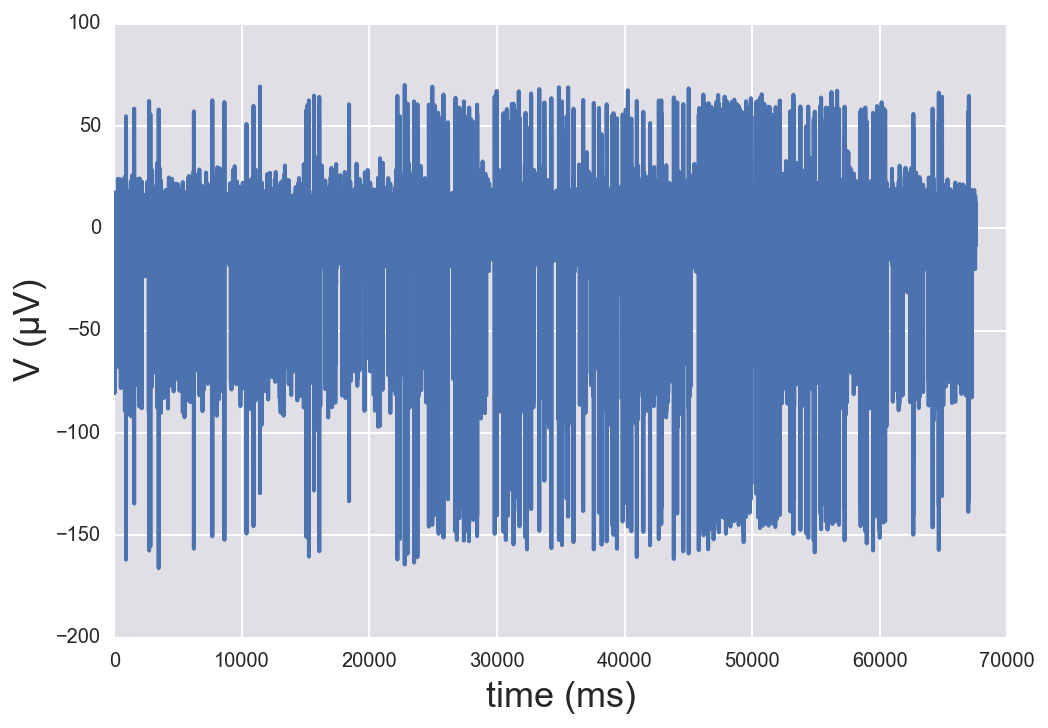

In [3]:
#Let's take a look at it
plt.plot(df['t (ms)'], df['V (µV)'])
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')

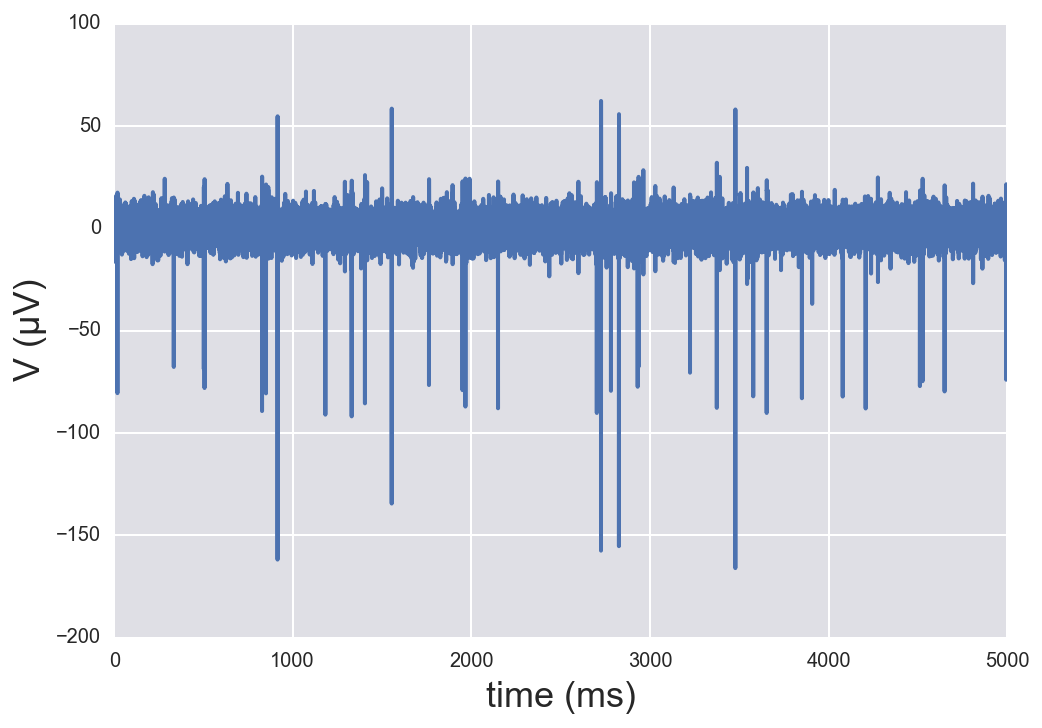

In [300]:
#Ok, so we need to zoom way in
plt.plot(df['t (ms)'][0:50000], df['V (µV)'][0:50000])
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')

# 6.2 a
By looking at the zoomed in graph, it can be seen that spikes can be defined as when the voltage drops below -50 µV.  We will use this threshold to find the locations of the spikes in time.

In [301]:
#Using the threshold of -50 uV to find all the spikes

all_spikes = np.where(np.logical_and(df[:-1]>-50, df[1:]<-50))
all_spikes = all_spikes[0]

# 6.2 b
Again, from looking at the graph, we can see the two different kinds of spikes.  The weak spikes drop below -50 µV, but the strong spikes drop below -100 µV and then goes above +50 µV.  We will use again use thresholding to distinguish these spike types

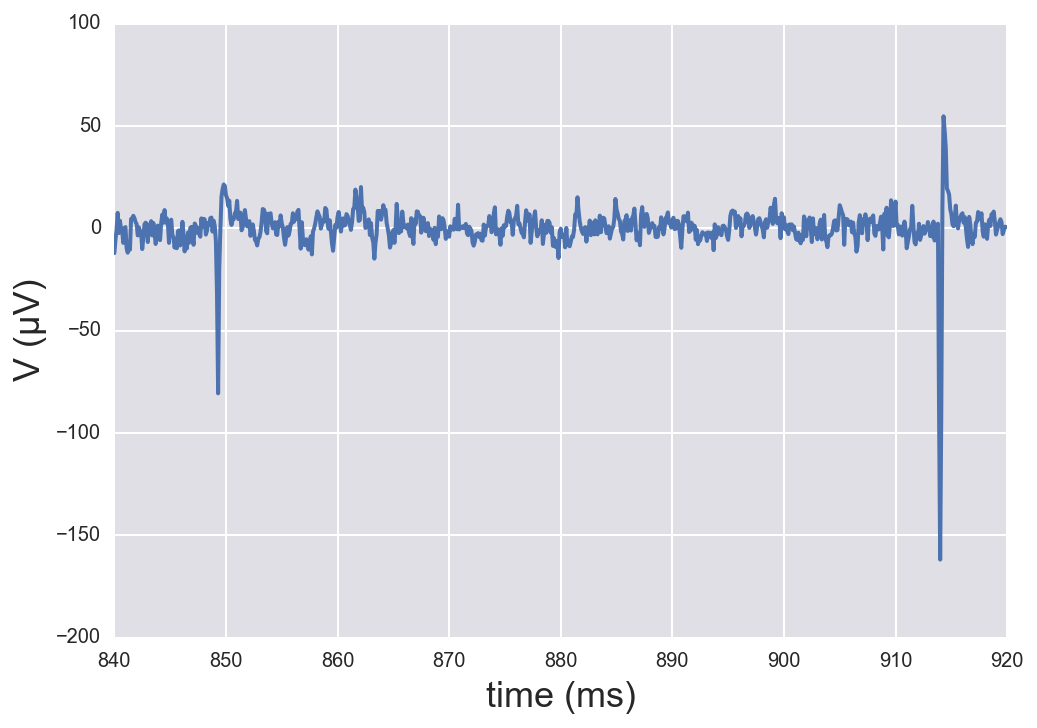

In [302]:
#Here is a piece of graph that shows a weak spike and a strong spike
plt.plot(df['t (ms)'][8400:9200], df['V (µV)'][8400:9200])
plt.xlabel('time (ms)')
plt.ylabel('V (µV)')

In [303]:
# Find all the strong spikes using the threshold of -100 uV
strong_spikes = np.where(np.logical_and(df[:-1]>-100, df[1:]<-100))
strong_spikes = strong_spikes[0]

In [304]:
strong_spikes_new = np.zeros(len(strong_spikes))
for l in range(len(strong_spikes)):
    spike = df['t (ms)'][strong_spikes[l]]
    spike = time.index(spike)
    w = spike -100
    e = spike +100
    localmin = np.min(df['V (µV)'][w:e])
    spike = volts.index(localmin)
    strong_spikes_new[l] = df['t (ms)'][spike]*10

In [305]:
all_spikes_new = np.zeros(len(all_spikes))
for l in range(len(all_spikes)):
    spike = df['t (ms)'][all_spikes[l]]
    spike = time.index(spike)
    w = spike -100
    e = spike +100
    localmin = np.min(df['V (µV)'][w:e])
    spike = volts.index(localmin)
    all_spikes_new[l] = df['t (ms)'][spike]*10

In [306]:
# By definition, the weak spikes are all spikes that are not strong spikes.
# This code will seperate the weak spikes from the strong spikes

weak_len = len(all_spikes)-len(strong_spikes)
weak_spikes = np.zeros(weak_len)
q = 0

for k in range(weak_len):
    spike = df['t (ms)'][all_spikes_new[k]]
    w = spike -10
    w = np.int(w*10)
    e = spike +10
    e = np.int(e*10)
    localmin = np.min(df['V (µV)'][w:e])
    if localmin > -100:
        weak_spikes[q] = all_spikes_new[k]
        q = q+1

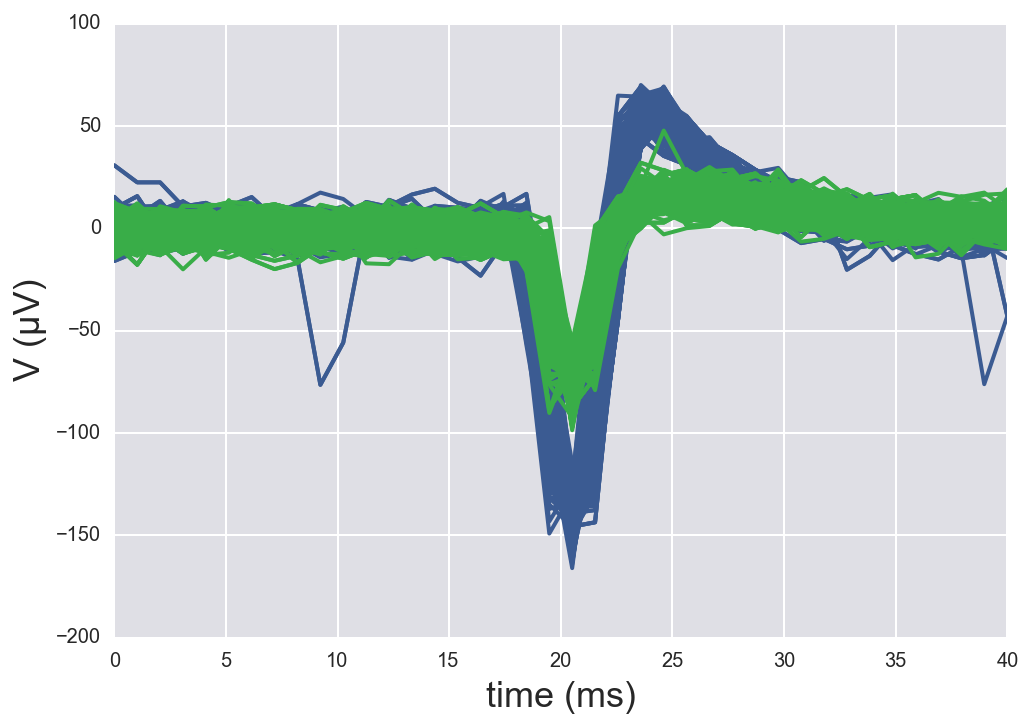

In [307]:
time = df['t (ms)'].tolist()
volts = df['V (µV)'].tolist()
empt = np.linspace(0,40,40)

for l in range(len(strong_spikes)):
    spike = df['t (ms)'][strong_spikes[l]]
    spike = time.index(spike)
    w = spike -100
    e = spike +100
    localmin = np.min(df['V (µV)'][w:e])
    spike = volts.index(localmin)
    w = spike -20
    e = spike +20
    plt.plot(empt, df['V (µV)'][w:e], sns.xkcd_rgb["denim blue"],)

for l in range(len(weak_spikes)):
    if weak_spikes[l] == 0:
        break
    spike = df['t (ms)'][weak_spikes[l]]
    spike = time.index(spike)
    w = spike -20
    e = spike +20
    plt.plot(empt, df['V (µV)'][w:e], sns.xkcd_rgb["medium green"])

plt.xlabel('time (ms)')
plt.ylabel('V (µV)')


# 6.2 c
Emperical probability distributions of inter-spike times, for strong and weak spikes.

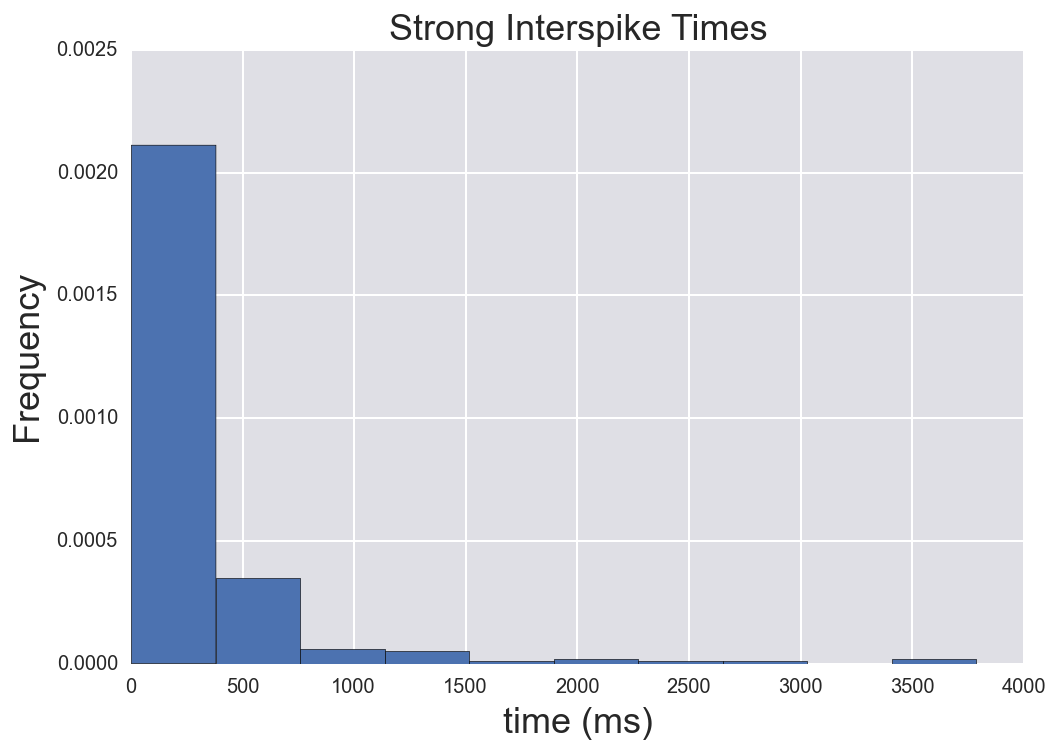

In [331]:
strong_interspike = np.zeros(len(strong_spikes)-1)
for y in range(len(strong_interspike)):
    spike_zero = df['t (ms)'][strong_spikes[y]]
    spike_one = df['t (ms)'][strong_spikes[y+1]]
    strong_interspike[y] = np.abs(spike_one-spike_zero)
plt.hist(strong_interspike, normed = True)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Strong Interspike Times')

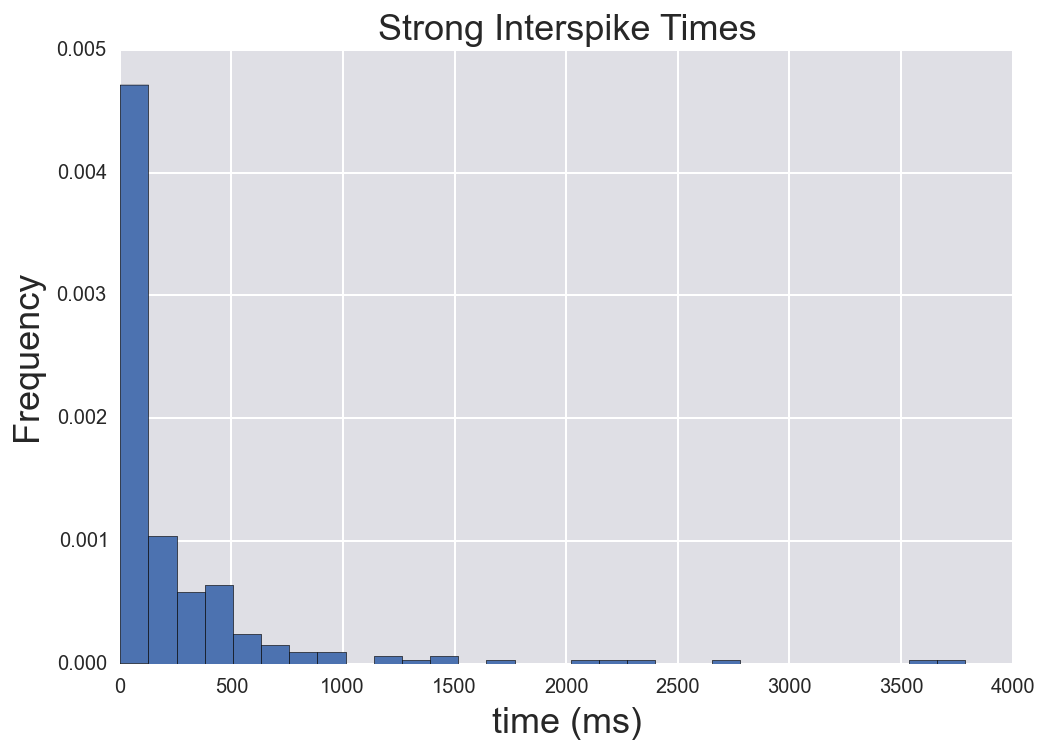

In [330]:
# The plot looks kind of exponential, but let's try some other scaling
plt.hist(strong_interspike, normed = True, bins = 30)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Strong Interspike Times')


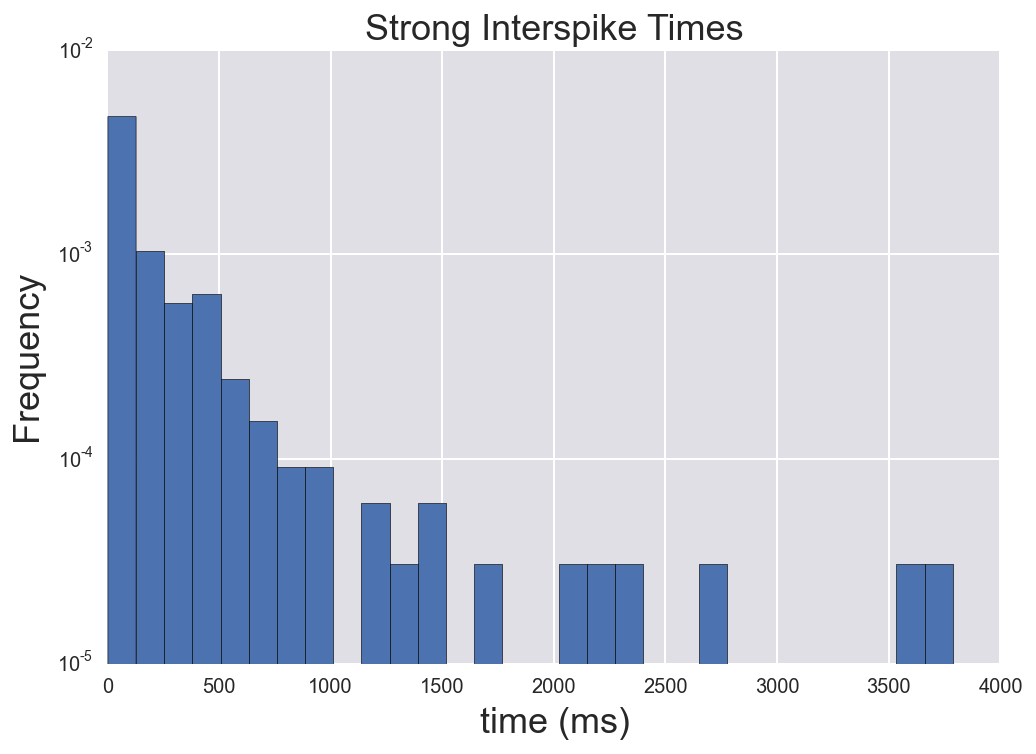

In [334]:
# Looks better with more bins.  Let's try a log plot on the y axis
plt.hist(strong_interspike, normed = True, bins = 30)
plt.yscale('log')
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Strong Interspike Times')

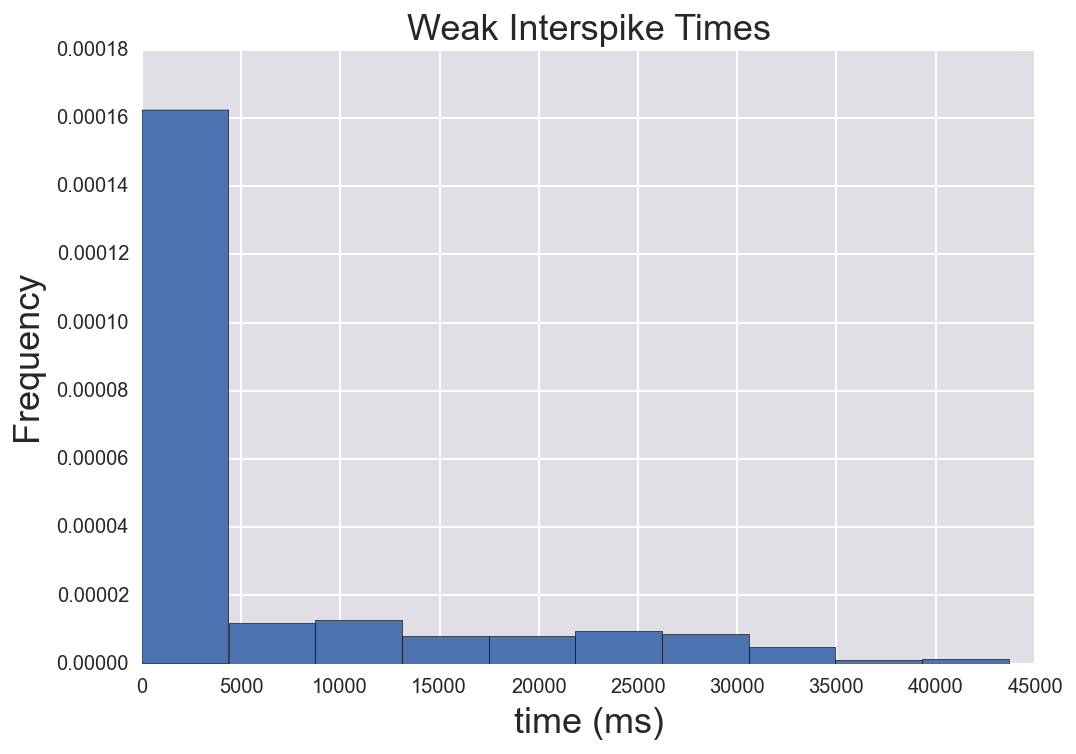

In [337]:
weak_interspike = np.zeros(len(weak_spikes)-1)
for y in range(len(weak_interspike)):
    spike_zero = df['t (ms)'][weak_spikes[y]]
    spike_one = df['t (ms)'][weak_spikes[y+1]]
    weak_interspike[y] = np.abs(spike_one-spike_zero)
plt.hist(weak_interspike, normed = True)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Weak Interspike Times')

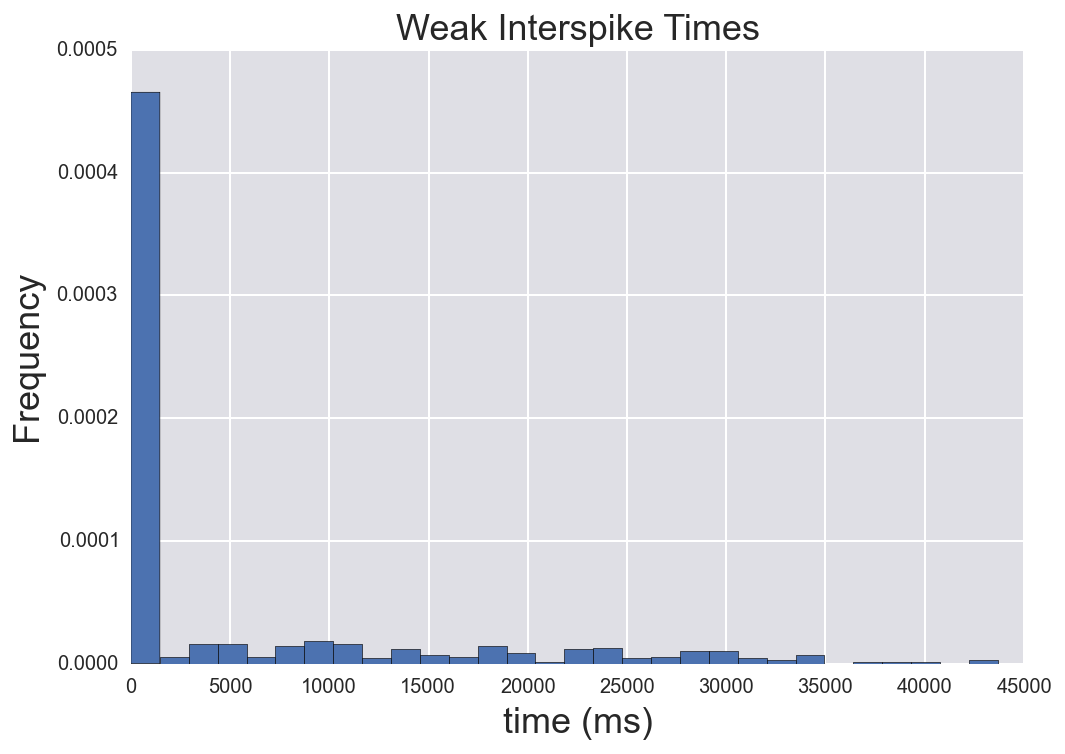

In [339]:
# Again, the plot looks kind of exponential, but let's try some other scaling
plt.hist(weak_interspike, normed = True, bins = 30)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Weak Interspike Times')


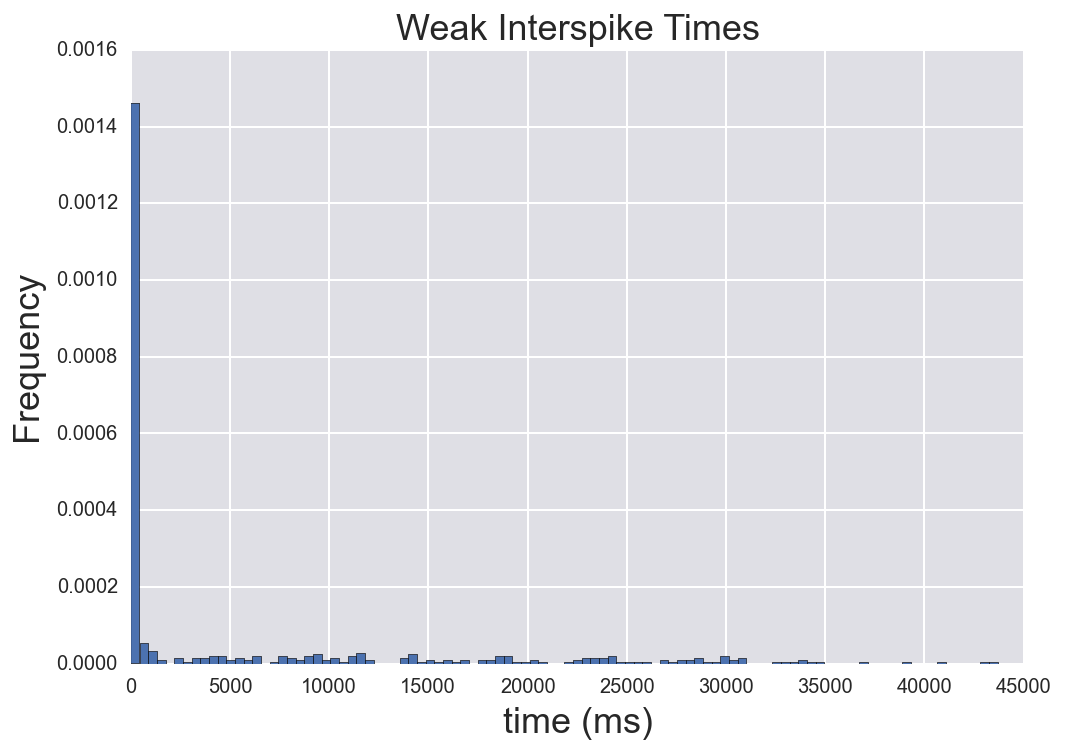

In [349]:
# Now it doesn't look very exponential.  Let's add more bins
plt.hist(weak_interspike, normed = True, bins = 100)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Weak Interspike Times')

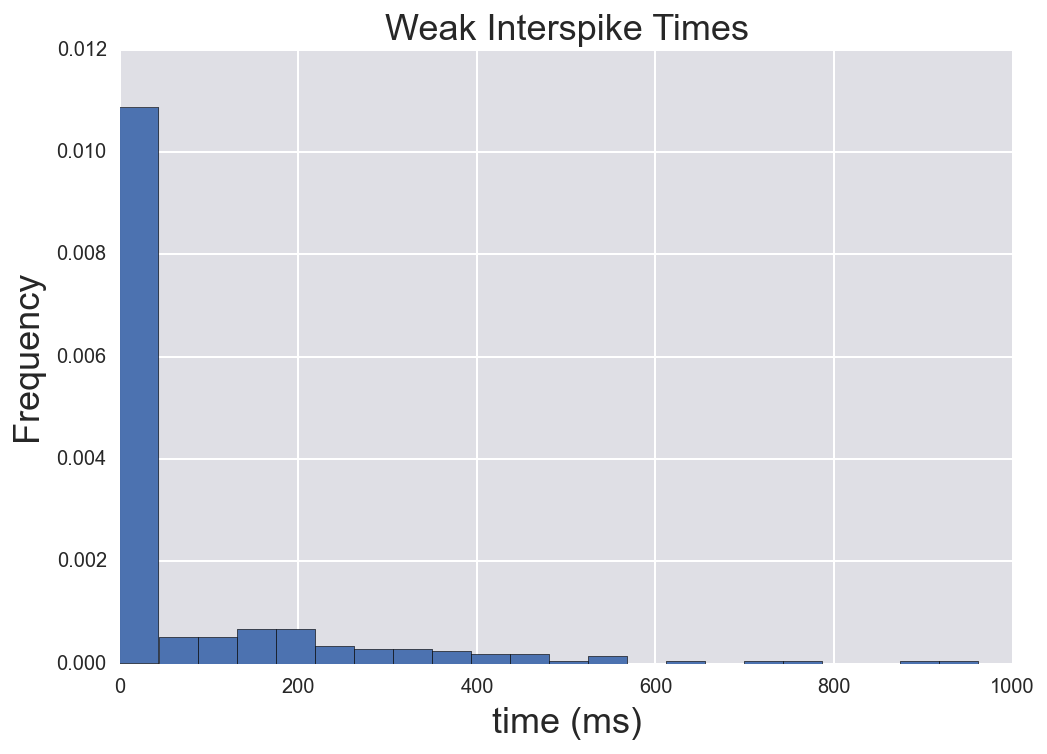

In [350]:
#Let's zoom in on the short timescale
plt.hist(weak_interspike, normed = True, bins = 1000)
plt.xlim(0,1000)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Weak Interspike Times')

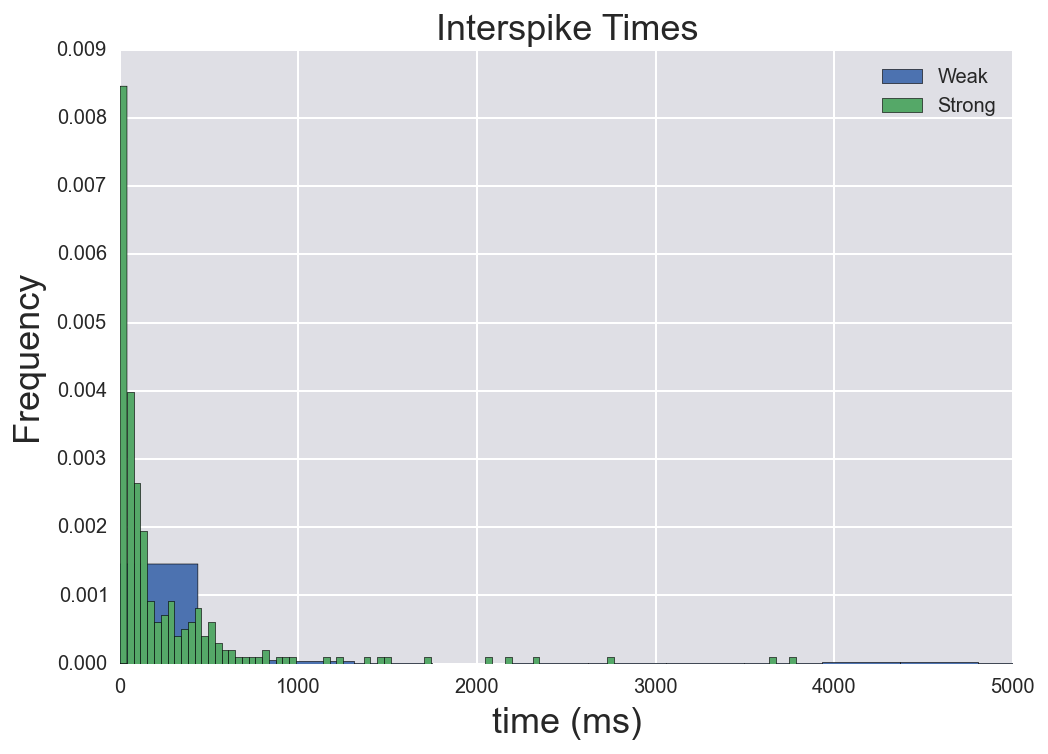

In [358]:
plt.hist(weak_interspike, normed = True, bins = 100, label = "Weak")
plt.hist(strong_interspike, normed = True, bins = 100, label = "Strong")
plt.xlim(0,5000)
plt.xlabel('time (ms)')
plt.ylabel('Frequency')
plt.title('Interspike Times')
plt.legend(loc='upper right')

# 6.2 c
The interspike times for strong spikes appears to fit an exponential distribution well, but for interspike times for weak spikes do not.  
The majority interspike times for the weak spikes are clusterted tightly between zero and twenty milliseconds, but after this window, the distribution is essentially flat out to about 40000 ms (40 seconds).
The exponential distribution of the strong spikes suggests that the strong spikes can be described by aa Poisson distribution, and not dependent on when the last strong spike occurred 
In contrast, the weak spikes are coupled to the occurence of a previous weak spike.  After a weak spike occurs, it is likely that another will occur shortly afterwords, but if the next spike does not occur within a few ms, then it can take a long time (anywhere from 1-40 seconds) before the cell will spike again.